In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

import warning
warning.filterwarnings('ignore')

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [13]:
df = pd.read_csv(
    (
        "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
        "master/ESS_practice_data/ESSdata_Thinkful.csv"
    )
).dropna()

# Define outcome and predictors.
# Set our outcome to 0 and 1.
y = df["partner"] - 1
X = df.loc[:, ~df.columns.isin(["partner", "cntry", "idno"])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df["cntry"])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]

<IPython.core.display.Javascript object>

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.


 - min_samples_split

In [ ]:
# Adjusted max_features/max_depth to have smaller grid
grid = {
    "gbc__subsample": [0.5, 0.75],
    "gbc__max_features": [0.5, 0.75],
    "gbc__max_depth": [5, 7],
    "gbc__min_samples_split": [2, 3],
    "gbc__loss": ["exponential"],
}

n_trees = 1000
learning_rate = 2 / n_trees

# fmt: off
pipeline = Pipeline([
    ("gbc", GradientBoostingClassifier(n_estimators=n_trees, 
                                      learning_rate=learning_rate))
])
# fmt: on

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1)
pipeline_cv.fit(X_train, y_train)

pipeline_cv.best_params_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [24]:
predict_train = pipeline_cv.predict(X_train)
predict_test = pipeline_cv.predict(X_test)

<IPython.core.display.Javascript object>

In [25]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.

# *** It's best to update this table for the drill
#  at the end of the lesson.  ***

# params = {"n_estimators": 500, "max_depth": 2, "loss": "deviance"}
#
# # Initialize and fit the model.
# clf = ensemble.GradientBoostingClassifier(**params)
# clf.fit(X_train, y_train)
#
# predict_train = clf.predict(X_train)
# predict_test = clf.predict(X_test)

<IPython.core.display.Javascript object>

### Evaluation of Model - Confusion Matrix Plot

based on the example here:

https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

In [26]:
def plot_confusion_matrix(
    cm, classes, normalize, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

Confusion matrix, without normalization


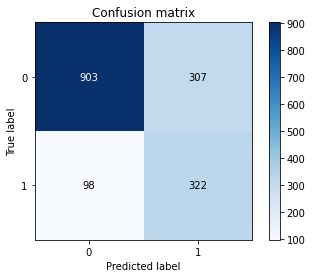

<IPython.core.display.Javascript object>

In [27]:
cm = confusion_matrix(predict_test, y_test)
plot_confusion_matrix(cm, [0, 1], False)

Normalized confusion matrix


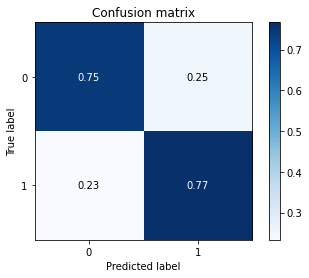

<IPython.core.display.Javascript object>

In [28]:
cm = confusion_matrix(predict_test, y_test)
plot_confusion_matrix(cm, [0, 1], True)

### Accuracy

In [29]:
pipeline_cv.score(X_test, y_test)

0.7515337423312883

<IPython.core.display.Javascript object>

### Precision

In [30]:
y_pred = clf.predict(X_test)
precision_score(y_test, y_pred)

0.7035647279549718

<IPython.core.display.Javascript object>

### Recall

In [31]:
recall_score(y_test, y_pred)

0.5961844197138315

<IPython.core.display.Javascript object>

Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

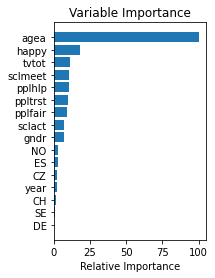

<IPython.core.display.Javascript object>

In [35]:
feature_importance = pipeline_cv.best_estimator_["gbc"].feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, but there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

You can learn more about the parameters for the gradient boost model [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and update the **params** table featured earlier, before we initialized and fit the model.

A few parameters to tune could be:
 - learning_rate
 - max_depth
 - n_estimators
 - loss
 - subsample
 - min_samples_split
 
You can then use the same metrics to evaluate your results.
          
Have fun!